In [14]:
import math
import pandas as pd
import random
import numpy as np
import requests
from random import sample, shuffle
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
from pyDOE2 import fullfact
from typing import List, Dict, Tuple, Any

In [3]:
data = pd.read_csv('./data/FinalData.csv')
data.head(5)

,ID,Name,Address,Latitude,Longitude,Opening Hours,Types,Rating,User Ratings Total
0,ChIJ-3wY7lEYQjERrJ9wTeoa-WQ,Blue Summer Hotel,"35 Tôn Thất Đạm, Xuân Hà, Thanh Khê, Đà Nẵng 5...",16.072062,108.201392,"['Monday: Open 24 hours', 'Tuesday: Open 24 ho...","['lodging', 'point_of_interest', 'establishment']",3.9,42.0
1,ChIJ-UBpozMYQjERDV3V1nrXEiM,Vinapha 2 Hotel,"19 Phạm Hồng Thái, Hải Châu 1, Hải Châu, Đà Nẵ...",16.067351,108.221777,['Monday: 12:00\u202fAM\u2009–\u200911:59\u202...,"['lodging', 'point_of_interest', 'establishment']",3.0,93.0
2,ChIJ13MshlIYQjERM4sqFu8lvyA,Ribo Coffee,"05 Thái Thị Bôi, Chính Gián, Thanh Khê, Đà Nẵn...",16.068272,108.201195,['Monday: 6:30\u202fAM\u2009–\u200910:30\u202f...,"['cafe', 'food', 'point_of_interest', 'establi...",4.1,306.0
3,ChIJ14kOf8kZQjERrdrrQPpiZKA,Mì Quảng Thi,"251 Hoàng Diệu, Nam Dương, Hải Châu, Đà Nẵng 5...",16.058546,108.217224,['Monday: 6:00\u202fAM\u2009–\u20091:29\u202fP...,"['restaurant', 'point_of_interest', 'food', 'e...",4.3,308.0
4,ChIJ2aT3UqMXQjER_rVaqCoyyWU,Chùa Linh Ứng,"Vườn Lâm Tỳ Ni, Hoàng Sa, Thọ Quang, Sơn Trà, ...",16.100261,108.277747,"['Monday: Open 24 hours', 'Tuesday: Open 24 ho...","['place_of_worship', 'point_of_interest', 'est...",4.7,1785.0


In [4]:
newData = data.loc[:, ["ID", "Name", "Latitude", "Longitude"]]
newData.head(5)

,ID,Name,Latitude,Longitude
0,ChIJ-3wY7lEYQjERrJ9wTeoa-WQ,Blue Summer Hotel,16.072062,108.201392
1,ChIJ-UBpozMYQjERDV3V1nrXEiM,Vinapha 2 Hotel,16.067351,108.221777
2,ChIJ13MshlIYQjERM4sqFu8lvyA,Ribo Coffee,16.068272,108.201195
3,ChIJ14kOf8kZQjERrdrrQPpiZKA,Mì Quảng Thi,16.058546,108.217224
4,ChIJ2aT3UqMXQjER_rVaqCoyyWU,Chùa Linh Ứng,16.100261,108.277747


In [5]:
#Cloudy Phan Dang Luu
latInit = 16.019110655988168
lngInit = 108.22903420822459

In [12]:
def haversineDistance(lat1, lng1, lat2, lng2):
    latRadian1 = math.radians(lat1)
    lngRadian1 = math.radians(lng1)
    latRadian2 = math.radians(lat2)
    lngRadian2 = math.radians(lng2)

    dlat = latRadian2 - latRadian1
    dlng = lngRadian2 - lngRadian1
    R = 6371e3

    a = math.sin(dlat/2) ** 2 + math.cos(latRadian1) * math.cos(latRadian2) * math.sin(dlng/2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c

In [15]:
def calFitness(routeDistance: float):
    return 1/(routeDistance + 1)

In [60]:
class Location:
    def __init__(self, x: float, y: float) -> None:
        self.x = x
        self.y =y

    def to_tupl(self) -> Tuple:
        return (self.x, self.y)

In [59]:
class Route:
    def __init__(self, route: List['Location']) -> None:
        self.route = route
        self.distance: float = 0.0
        self.fitness: float = 0.0
    
    def routeDistance(self) -> float:
        if self.distance == 0: 
            pathDistance = 0.0  
            for index in range(0, len(self.route) - 1):
                dist = haversineDistance(self.route[index].x, self.route[index].y, self.route[index + 1].x, self.route[index + 1].y)
                pathDistance+= dist
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self) -> float:
        if self.fitness == 0:
            self.fitness = calFitness(self.routeDistance())
        return self.fitness
    
    def coordinates(self) -> Tuple[List[float], List[float]]:
        x_list, y_list = [], []
        for location in self.route:
            x_list.append(location.to_tupl()[0])
            y_list.append(location.to_tupl()[1])
        return x_list, y_list

In [157]:
def nearestNeighborAlgorithm(data, n = 20):
    startPoint = (latInit, lngInit)
    listPoints = []
    listDetailsPoint = []

    currentPoint = startPoint
    listPoints.append(currentPoint)
    detailsPoint = [ 0, 'Cloudy', currentPoint]
    listDetailsPoint.append(detailsPoint)

    while(len(listPoints) < n):
        minDistance = float('inf')
        nextPoint = None
        name = None
        index = 0

        for i , row in data.iterrows():
            
            lat = row['Latitude']
            lng = row['Longitude']
            if(lat, lng) not in listPoints:
                dist = haversineDistance(currentPoint[0], currentPoint[1], lat, lng)
                
                if dist < minDistance:
                    minDistance = dist
                    nextPoint = (lat, lng)
                    name = row['Name']
                    index = i + 1
            
        if nextPoint is not None:
            currentPoint = nextPoint
            listPoints.append(currentPoint)
            detailsNewPoint = [index, name, currentPoint]
            listDetailsPoint.append(detailsNewPoint)

    endPoint = startPoint
    listPoints.append(endPoint)
    listDetailsPoint.append(detailsPoint)

    return listPoints, listDetailsPoint

In [85]:
def initPopulation(populationSize: int, listInitLocations: List = None) -> List[List['Location']]:
    population = []

    listSamples = list(range(1, len(listInitLocations) - 1))

    for _ in range(populationSize):
        if listInitLocations is not None:
            listRandoms = random.sample(listSamples, len(listSamples))
            newLocation = [listInitLocations[0]] + [listInitLocations[i] for i in listRandoms] + [listInitLocations[-1]]

            population.append(newLocation)

    return population

In [88]:
def rankRoutes(population: List[List['Location']]) -> List[Tuple[int, float]]:
    fitnessResults: Dict = {}
    for i in range(len(population)):
        fitnessResults[i] = Route(population[i]).routeFitness()

    return sorted(fitnessResults.items(), key=lambda x: x[1], reverse=True)

In [103]:
def touramentSelection(populationRanked: List[Tuple[int, float]], numElites: int = 0):
    df = pd.DataFrame(np.array(populationRanked), columns=["Index", "Fitness"])
    df["weights"] = 100 * df.Fitness / df.Fitness.sum()
    selection_results = df.sample(n=len(populationRanked)-numElites,
                                  replace=True,
                                  weights=df.weights
                                  ).values[:, 0]
    elite_results = df.iloc[0:numElites, 0].values
    selection_results = list(map(int, np.concatenate(
        (selection_results, elite_results)).tolist()))
    return selection_results

In [29]:
def mergedPoint(population: List[List['Location']], selection_results: List[int]) -> List[List['Location']]:
    output: List = []
    for i in range(len(selection_results)):
        index = selection_results[i]
        output.append(population[index])
    return output

In [28]:
def crossoverMix(parent1: List['Location'], parent2: List['Location']):
    point1, point2 = random.sample(range(1, len(parent1)-1), 2)
    begin = min(point1, point2)
    end = max(point1, point2)

    child1_begin = parent1[:begin]
    child1_end = parent1[end:]

    child1 = child1_begin + child1_end
    child2 = parent2[begin:end+1]

    child1_remain = [item for item in parent2[1:-1] if item not in child1]
    child2_remain = [item for item in parent1[1:-1] if item not in child2]

    child1 = child1_begin + child1_remain + child1_end
    child2 += child2_remain

    child2.insert(0, parent2[0])
    child2.append(parent2[0])

    return child1, child2

In [101]:
def crossoverPopulation(mergedPoint: List[List['Location']], numElites: int = 0):
    children: List = []
    numNonElite = len(mergedPoint) - numElites

    individuals = random.sample(mergedPoint, len(mergedPoint))

    for i in range(1, numElites + 1):
        children.append(mergedPoint[-i])

    for i in range(0, numNonElite):
        child1, child2 = crossoverMix(individuals[i], individuals[len(mergedPoint) -i -1])
        children.append(child1)

    return children

In [34]:
def mutation(individual: list['Location'], mutationRate):
    if random.random() < mutationRate:
        mutation_index_1, mutation_index_2 = random.sample(range(1, len(individual) - 1), 2)
        begin = min(mutation_index_1, mutation_index_2)
        end = max(mutation_index_1, mutation_index_2)

        individual_begin = individual[:begin]
        individual_end = individual[end+1:]

        individual_center = individual[begin:end+1]
        individual_center.reverse()
        
        individual = individual_begin + individual_center + individual_end

    return individual

In [35]:
def mutatePopulation(children: List[List['Location']], mutationRate: float = 0):
    mutatedPopulation: List = []

    for individual in range(0, len(children)):
        mutatedIndividual = mutation(children[individual], mutationRate)
        mutatedPopulation.append(mutatedIndividual)
    return mutatedPopulation

In [95]:
def nextGeneration(currentGen: List[List['Location']], numElites: int, mutationRate: float = 0):
    populationRanked = rankRoutes(currentGen)

    bestCurrentGenRoute = Route(currentGen[populationRanked[0][0]])
    bestCurrentGenFitness = bestCurrentGenRoute.routeFitness()
    bestCurrentGenDistance = bestCurrentGenRoute.routeDistance()

    selectionResults = touramentSelection(populationRanked, numElites)
    individuals = mergedPoint(currentGen, selectionResults)
    children = crossoverPopulation(individuals, numElites)
    nextGeneration = mutatePopulation(children)

    return nextGeneration, bestCurrentGenRoute, bestCurrentGenFitness, bestCurrentGenDistance

In [139]:
def geneticAlgorithm(populationSize: int, numElites: int, numGens: int, mutationRate: float = 0.005, listInitLocations: List = None):
    population = initPopulation(populationSize, listInitLocations)
    bestInitialRoute = Route(population[rankRoutes(population)[0][0]])
    print("Initial Distance: " + str(bestInitialRoute.routeDistance()))

    bestRouteByGen: List = []
    bestFitnessByGen: List = []
    bestDistanceByGen: List = []

    for _ in range(0, numGens):
        population, bestCurrentGenRoute, bestCurrentGenFitness, bestCurrentGenDistance = \
            nextGeneration(population, numElites, mutationRate)
        
        bestRouteByGen.append(bestCurrentGenRoute)
        bestFitnessByGen.append(bestCurrentGenFitness)
        bestDistanceByGen.append(bestCurrentGenDistance)

    bestFinalRoute = Route(population[rankRoutes(population)[0][0]])
    print("Final Distance: " + str(bestFinalRoute.routeDistance()))

    params = [populationSize,  numElites, numGens, mutationRate, listInitLocations]
    return bestFinalRoute, bestInitialRoute, bestFitnessByGen, bestDistanceByGen, params

In [169]:
listPoints, listDetailsPoint = nearestNeighborAlgorithm(newData)
listPoints

[(16.019110655988168, 108.22903420822459),
 (16.0359504, 108.2242925),
 (16.0385547, 108.2233731),
 (16.0387805, 108.2254072),
 (16.0383924, 108.2266751),
 (16.0404534, 108.2283843),
 (16.0410321, 108.2243161),
 (16.0411297, 108.2227389),
 (16.0442346, 108.2227286),
 (16.046858, 108.2212214),
 (16.049417, 108.2233),
 (16.0490718, 108.2241468),
 (16.0483415, 108.2267041),
 (16.0510826, 108.2290629),
 (16.0503877, 108.2299175),
 (16.0563483, 108.2220345),
 (16.0581055, 108.2232435),
 (16.0603007, 108.2232677),
 (16.062867, 108.2231386),
 (16.0634798, 108.2236939),
 (16.019110655988168, 108.22903420822459)]

In [170]:
listInitalLocations = [Location(i[0], i[1]) for i in listPoints]

In [190]:
bfr, brbg, bfbg, bdbg, params = geneticAlgorithm(3000, 500, 50, 0.005, listInitalLocations)

Initial Distance: 17974.387240753604
Final Distance: 11092.967757123235


In [192]:
bestDistanceByMutation = []
i = 0.001
while(i <= 0.3):
    bfr, brbg, bfbg, bdbg, params = geneticAlgorithm(3000, 500, 50, i, listInitalLocations)
    bestDistanceByMutation.append(bdbg)
    i += 0.001


Initial Distance: 18708.089215572887
Final Distance: 11092.967757123235
Initial Distance: 18419.359120237037
Final Distance: 11095.953841206543
Initial Distance: 19181.929657055494
Final Distance: 11140.79507618853
Initial Distance: 18298.044115759116
Final Distance: 11092.967757123235
Initial Distance: 18135.742041003377
Final Distance: 11092.967757123235
Initial Distance: 17182.182408857756
Final Distance: 11095.953841206541
Initial Distance: 17784.609890062784
Final Distance: 11092.967757123235
Initial Distance: 18554.340498259626
Final Distance: 11095.953841206541
Initial Distance: 18816.962942690654
Final Distance: 11095.953841206541
Initial Distance: 19912.96876150476
Final Distance: 11150.504027193798
Initial Distance: 18991.101082284007
Final Distance: 11150.504027193798
Initial Distance: 19345.824199143208
Final Distance: 11159.079033433782
Initial Distance: 16783.771335687332
Final Distance: 11092.967757123235
Initial Distance: 17668.913540912752
Final Distance: 11092.9677571

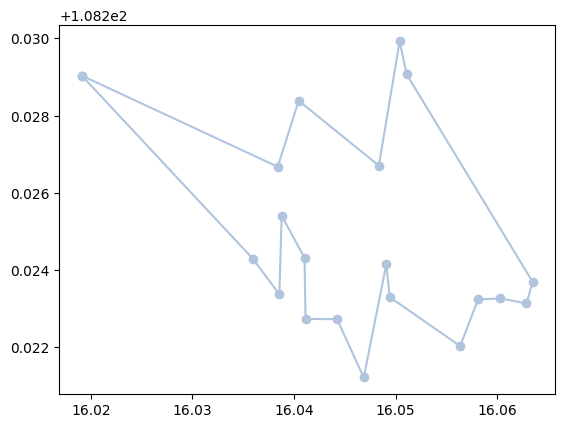

In [185]:
x, y = bfr.coordinates()
plt.plot(x, y, **{'color': 'lightsteelblue', 'marker': 'o'})
plt.show()

In [167]:
def distancePlot(bestDistanceByGen: List[int], params: List):
    plt.plot(bestDistanceByGen)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    s = "popSize: " + str(params[0]) + "\nnumCities: " + str(params[1]) + \
        "\nnumGens: " + str(params[3]) + "\nmutationRate: " + str(params[4])
    # plt.text(s)
    # plt.text(0, bestDistanceByGen[0], round(bestDistanceByGen[0],1))
    plt.text(len(bestDistanceByGen),
             bestDistanceByGen[-1], round(bestDistanceByGen[-1],1))
    plt.show()

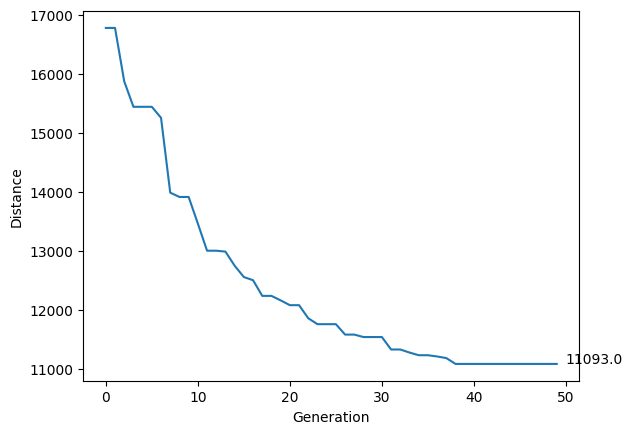

In [186]:
distancePlot(bdbg, params)